In [2]:
# Importing libraries

import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn,optim
from torch.utils import data

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)


In [4]:
HAPPY_COLORS_PALETTE=['#01BEFE','#FFDD00','#FF006D',"#ADFF02",'#8F00FF']


In [5]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [6]:
rcParams['figure.figsize']=12,8

In [7]:
RANDOM_SEED =42

In [8]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [42]:
df=pd.read_csv('reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOGMyM6UFwCmkuOVGlLqXvFbe5eShfdCqFXCOe1...,M.A Ibrahim,https://play-lh.googleusercontent.com/a-/AOh14...,"Nice interface, very annoying registration pro...",1,3,1.0.0,2022-01-22 06:36:56,NaN,NaN,most_relevant,ng.gov.cbn.speed.merchant.temp
1,gp:AOqpTOFsxW1PUZN0n8gNTzVTatv2y8QmTks_V1pviLd...,DANIEL CHUKWUKERE,https://play-lh.googleusercontent.com/a-/AOh14...,Disaster waiting to happen.. I knew the app ha...,1,76,1.0.0,2021-10-28 07:38:39,NaN,NaN,most_relevant,ng.gov.cbn.speed.merchant.temp
2,gp:AOqpTOEPBd_fDfB6yvYONmmFI-getybIwCm1o7BePoE...,Lawal Aremu,https://play-lh.googleusercontent.com/a-/AOh14...,Even after following the advice of the CBN age...,1,3,1.0.0,2021-11-24 13:40:55,"Hello,\nPlease write to us via mail at helpdes...",2021-11-18 15:19:56,most_relevant,ng.gov.cbn.speed.merchant.temp
3,gp:AOqpTOGn0sLMYg2kvKt4sCjWOUBtjhI4OodBnpcS5EP...,David Godwin,https://play-lh.googleusercontent.com/a/AATXAJ...,It's been more than 20days I downloaded this a...,1,3,1.0.0,2021-11-16 02:53:49,"Hi,\nPlease write to us via mail at helpdesk@e...",2021-11-18 15:20:08,most_relevant,ng.gov.cbn.speed.merchant.temp
4,gp:AOqpTOGCRVHZJUw2uOWrN_sIfb3vtP0qZJBDDh0CY_H...,Kolawole Isaac,https://play-lh.googleusercontent.com/a-/AOh14...,This is like re-inventing the wheel. The purpo...,1,35,1.0.0,2021-10-27 22:22:40,NaN,NaN,most_relevant,ng.gov.cbn.speed.merchant.temp


In [43]:
df.shape

(2903, 12)

In [44]:
# Check the data type and information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2903 entries, 0 to 2902
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              2903 non-null   object
 1   userName              2903 non-null   object
 2   userImage             2903 non-null   object
 3   content               2903 non-null   object
 4   score                 2903 non-null   int64 
 5   thumbsUpCount         2903 non-null   int64 
 6   reviewCreatedVersion  2631 non-null   object
 7   at                    2903 non-null   object
 8   replyContent          1008 non-null   object
 9   repliedAt             1008 non-null   object
 10  sortOrder             2903 non-null   object
 11  appId                 2903 non-null   object
dtypes: int64(2), object(10)
memory usage: 272.3+ KB


C:\Users\Salaudeen Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'review score')

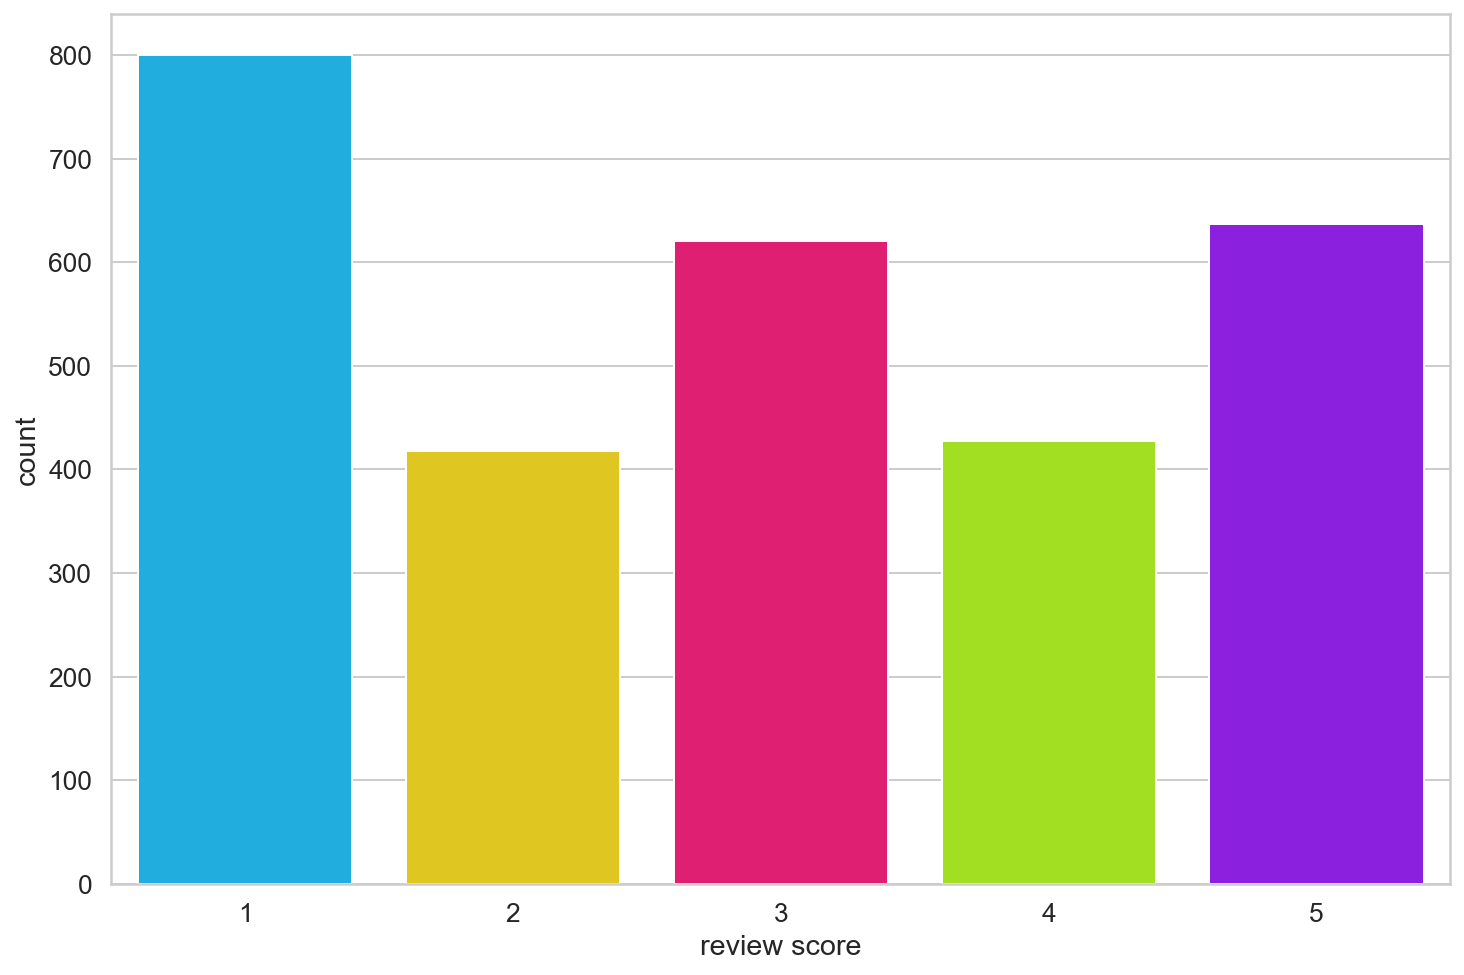

In [45]:
# ploting the app score with seaborn
sns.countplot(df.score)
# labeling the xasis
plt.xlabel('review score')

In [46]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <=2:
        return 0
    elif rating ==3:
        return 1
    else:
        return 2

In [47]:
df['sentiment'] =df.score.apply(to_sentiment)

In [48]:
# Classifying the sentiment into different class
class_names =['negative', 'neutral', 'positive']

C:\Users\Salaudeen Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

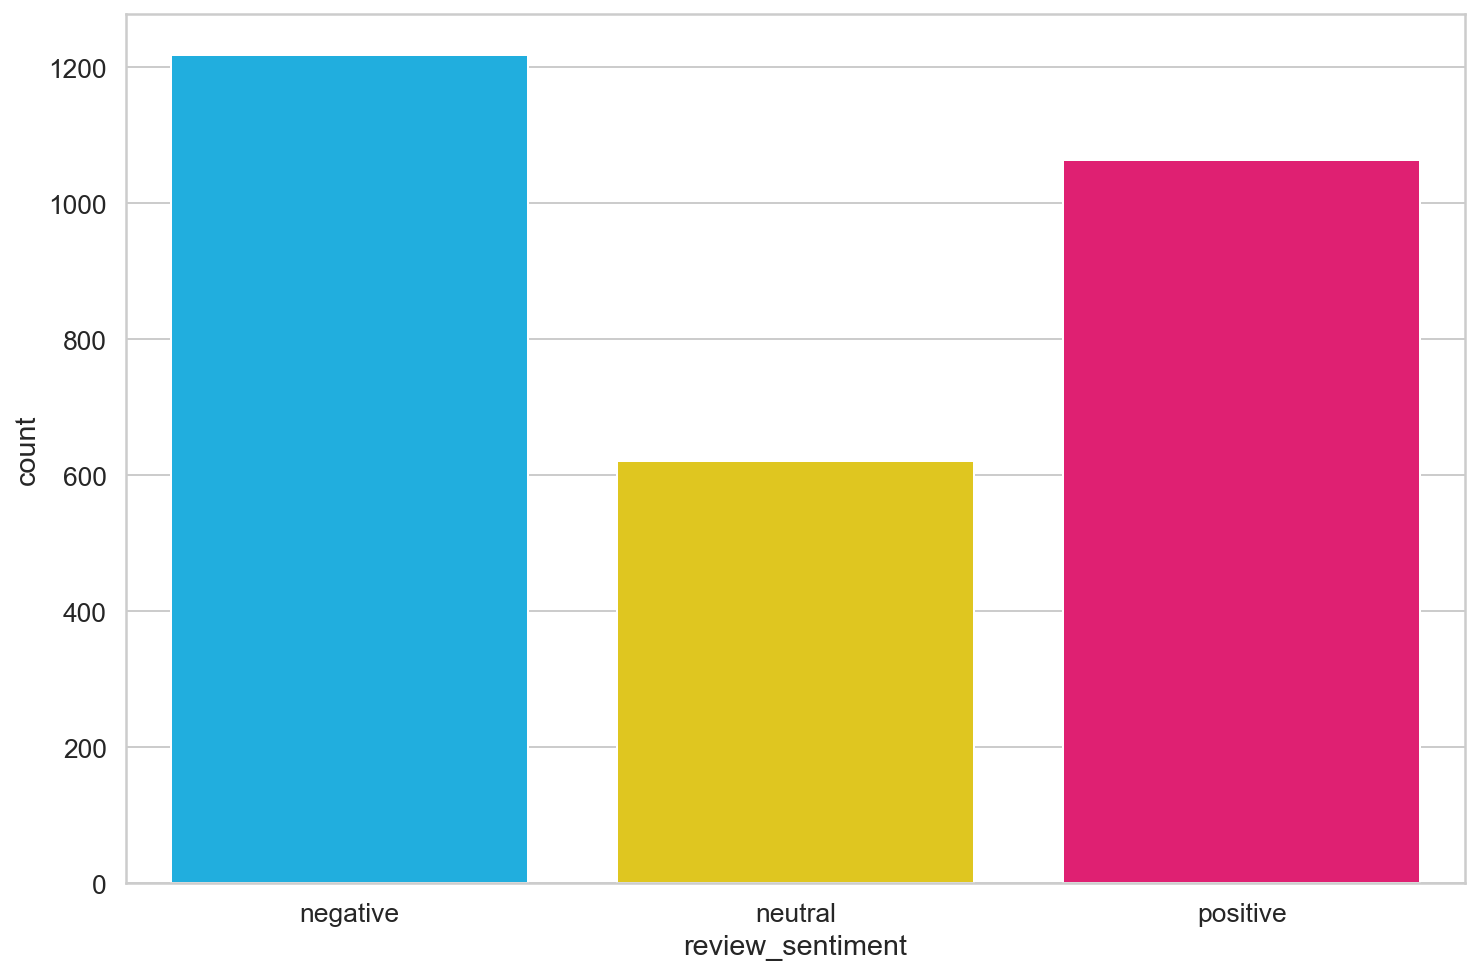

In [49]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review_sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

In [17]:
#using BERT transformation model
tokenizer=transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [25]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [26]:
# tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [18]:
# # testing the tokenizer with sample texts
# sample_txt ='when was I last outside? I am stuck at home for 2 weeks'

In [27]:
# tokens = tokenizer.tokenize(sample_txt)

In [28]:
# df2=df[['content']]
# df2['content'].iloc[1]

"Disaster waiting to happen.. I knew the app had no potential but I needed to see the extent to which it was utterly pointless. I'm an app developer and honestly even a 14 year old beginner is not this terrible, can't believe this app was designed by a full team of software developers."

In [29]:
# def sentiment_score(review):
#     tokens=tokenizer.encode(review, return_tensors='pt')
#     result = model(tokens)
#     return int(torch.argmax(result.logits))+1

In [31]:
sentiment_score(df2['content'].iloc[2])

1

In [34]:
# df2['sentiment_score']= df2['content'].apply(lambda x: sentiment_score(x[:512]))

<ipython-input-34-fd956fddadf8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment_score']= df2['content'].apply(lambda x: sentiment_score(x[:512]))


In [35]:
df2.head()

,content,sentiment_score
0,"Nice interface, very annoying registration pro...",2
1,Disaster waiting to happen.. I knew the app ha...,1
2,Even after following the advice of the CBN age...,1
3,It's been more than 20days I downloaded this a...,1
4,This is like re-inventing the wheel. The purpo...,1


In [37]:
df2['sentiment'] =df2.sentiment_score.apply(to_sentiment)

<ipython-input-37-e45a69524a35>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment'] =df2.sentiment_score.apply(to_sentiment)


In [38]:
df2.head()

,content,sentiment_score,sentiment
0,"Nice interface, very annoying registration pro...",2,0
1,Disaster waiting to happen.. I knew the app ha...,1,0
2,Even after following the advice of the CBN age...,1,0
3,It's been more than 20days I downloaded this a...,1,0
4,This is like re-inventing the wheel. The purpo...,1,0


In [39]:
# Classifying the sentiment into different class
class_names =['negative', 'neutral', 'positive']

C:\Users\Salaudeen Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

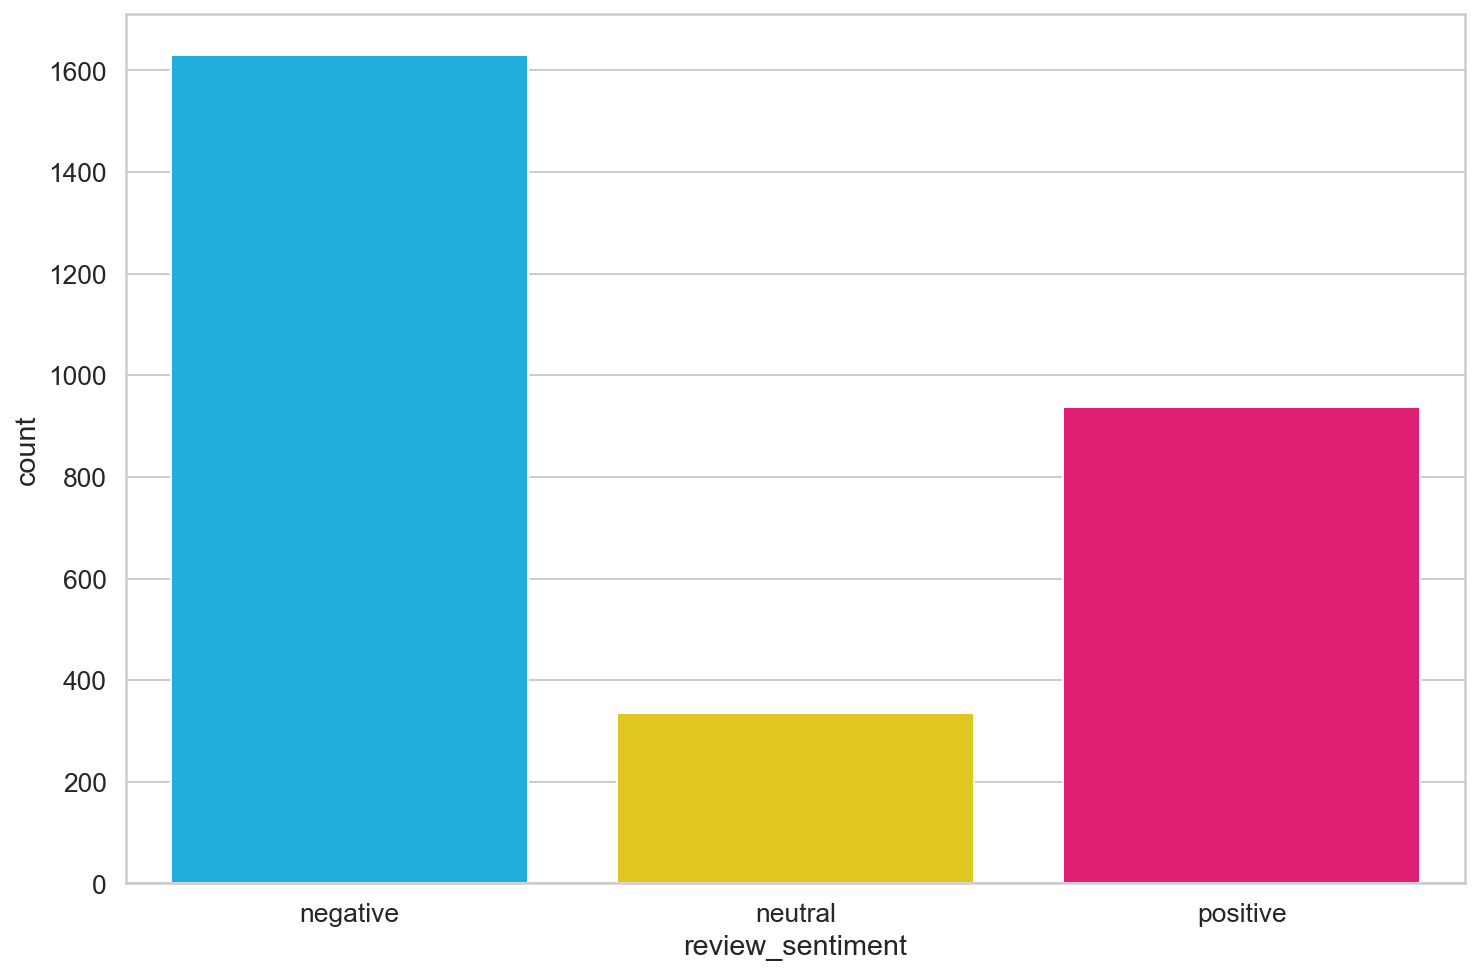

In [50]:
ax = sns.countplot(df2.sentiment)
plt.xlabel('review_sentiment')
ax.set_xticklabels(class_names)

In [51]:
print(tokens)

['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks']


In [52]:
token_ids =tokenizer.convert_tokens_to_ids(tokens)
print(len(tokens))
print(token_ids)

14
[10704, 10140, 151, 11706, 16751, 136, 151, 10345, 27048, 10160, 11402, 10139, 123, 19746]


In [53]:
print(f'Sentence: {sample_txt}')
print(f' Tokens: {tokens}')
print(f' Token IDs: {token_ids}')

Sentence: when was I last outside? I am stuck at home for 2 weeks
 Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks']
 Token IDs: [10704, 10140, 151, 11706, 16751, 136, 151, 10345, 27048, 10160, 11402, 10139, 123, 19746]


In [54]:
###Special Token

In [55]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [56]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [57]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [58]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [59]:
# Creating a variable encoding
encoding = tokenizer.encode_plus(
                sample_txt, max_length=32, add_special_tokens =True, pad_to_max_length=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Salaudeen Ibrahim\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [60]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [61]:
encoding['input_ids']

tensor([[  101, 10704, 10140,   151, 11706, 16751,   136,   151, 10345, 27048,
         10160, 11402, 10139,   123, 19746,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [62]:
len(encoding['input_ids'][0])

32

In [63]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [64]:
## Choosing Sequence Length
token_lens=[]
for txt in df.content:
    tokens=tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

C:\Users\Salaudeen Ibrahim\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


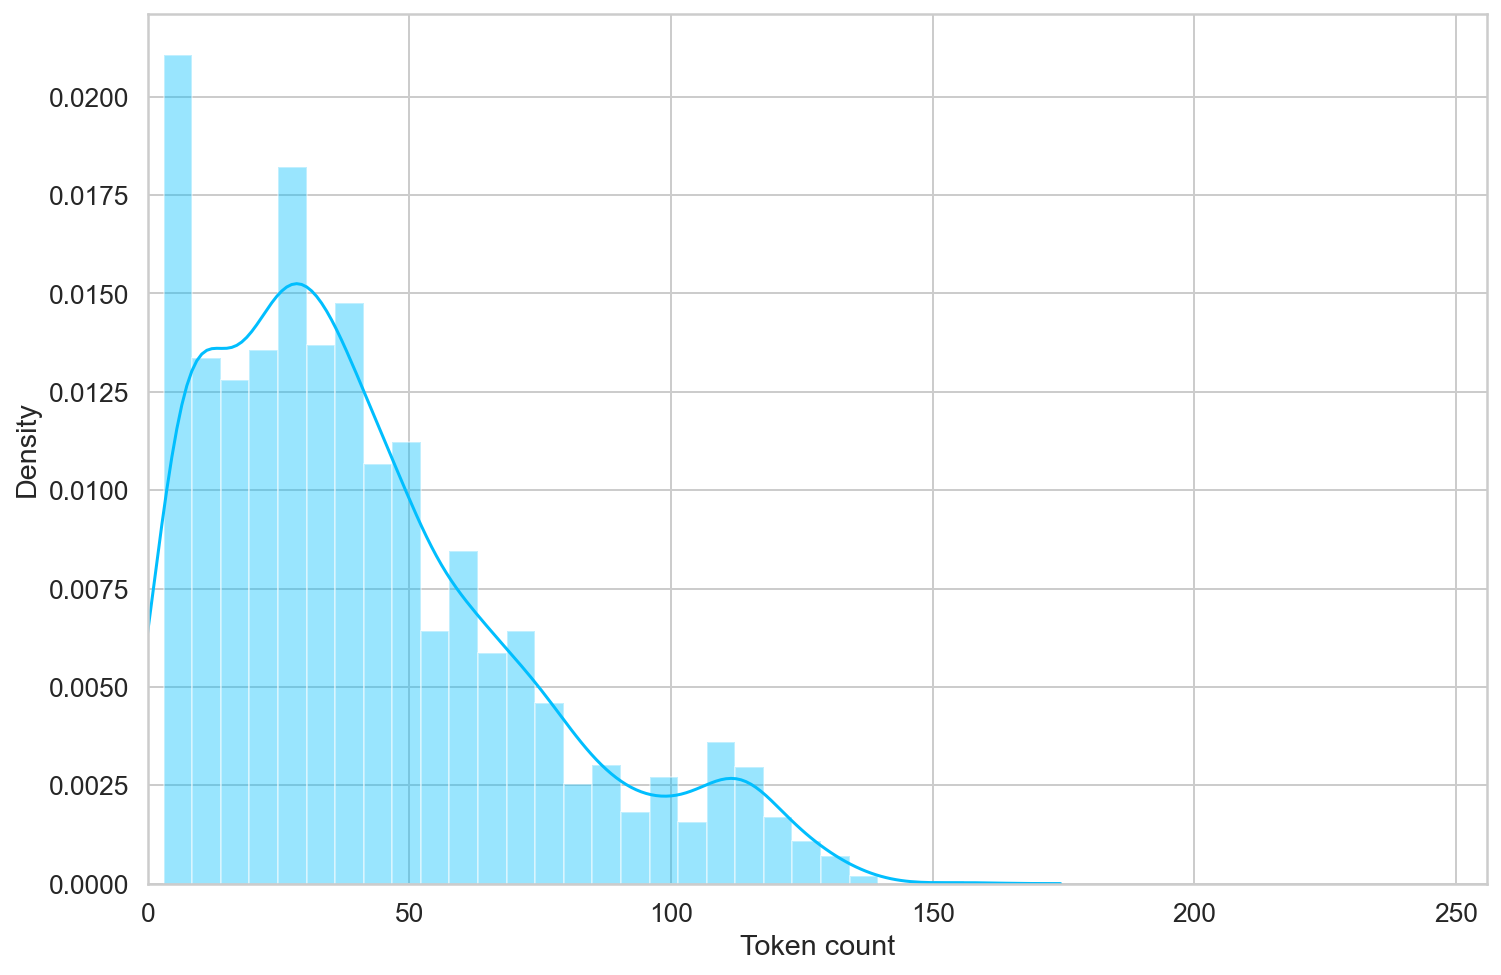

In [65]:
sns.distplot(token_lens)
plt.xlim([0,256]);
plt.xlabel('Token count');


## Create a Dataset

In [66]:
class GPReviewDataset(data.Dataset):
    
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target =target
        self.tokenizer =tokenizer
        self.max_len =max_len
    
    def __len__ (self):
        return len(self.review)
    
    def __getitem__ (self, item):
        review =str(self, review[item])
        
        encoding = tokenizer.encode_plus(
            review, max_length=self.max_len, 
            add_special_tokens =True, pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt')
        return {
            'input_ids':encoding[input_ids],
            'attention_mask': encoding['attention_mask'],
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }

In [67]:
# Creating constant variables
MAX_LEN =128
BATCH_SIZE = 8
EPOCHS = 20

In [68]:
df_train, df_test =train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [69]:
df_train.shape, df_val.shape, df_test.shape

((2322, 13), (290, 13), (291, 13))

In [70]:
 # Data loader function 
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    review=df.content.to_numpy(),
    target=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return data.DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [73]:


train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [76]:
print(df_train['input_ids'].shape)

KeyError: 'input_ids'

In [ ]:
df2=df[['content']]
df2.head()